In [24]:
from codecademySQL import sql_query

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from math import sqrt
from numpy import mean
import scipy.stats as stats
from scipy.stats import sem, t, ttest_ind, chi2, chi2_contingency

In [2]:
# Examine visits 
sql_query('''
SELECT *
FROM visits
LIMIT 5
''')

,index,first_name,last_name,email,gender,visit_date
0,0,Karen,Manning,Karen.Manning@gmail.com,female,5-1-17
1,1,Annette,Boone,AB9982@gmail.com,female,5-1-17
2,2,Salvador,Merritt,SalvadorMerritt12@outlook.com,male,5-1-17
3,3,Martha,Maxwell,Martha.Maxwell@gmail.com,female,5-1-17
4,4,Andre,Mayer,AndreMayer90@gmail.com,male,5-1-17


In [3]:
# Examine fitness_tests 
sql_query('''
SELECT *
FROM fitness_tests
LIMIT 5
''')

,index,first_name,last_name,email,gender,fitness_test_date
0,0,Kim,Walter,KimWalter58@gmail.com,female,2017-07-03
1,1,Tom,Webster,TW3857@gmail.com,male,2017-07-02
2,2,Marcus,Bauer,Marcus.Bauer@gmail.com,male,2017-07-01
3,3,Roberta,Best,RB6305@hotmail.com,female,2017-07-02
4,4,Carrie,Francis,CF1896@hotmail.com,female,2017-07-05


In [4]:
# Examine applications 
sql_query('''
SELECT *
FROM applications
LIMIT 5
''')

,index,first_name,last_name,email,gender,application_date
0,0,Roy,Abbott,RoyAbbott32@gmail.com,male,2017-08-12
1,1,Agnes,Acevedo,AgnesAcevedo1@gmail.com,female,2017-09-29
2,2,Roberta,Acevedo,RA8063@gmail.com,female,2017-09-15
3,3,Darren,Acosta,DAcosta1996@hotmail.com,male,2017-07-26
4,4,Vernon,Acosta,VAcosta1975@gmail.com,male,2017-07-14


In [5]:
# Examine purchases 
sql_query('''
SELECT *
FROM purchases
LIMIT 5
''')

,index,first_name,last_name,email,gender,purchase_date
0,0,Roy,Abbott,RoyAbbott32@gmail.com,male,2017-08-18
1,1,Roberta,Acevedo,RA8063@gmail.com,female,2017-09-16
2,2,Vernon,Acosta,VAcosta1975@gmail.com,male,2017-07-20
3,3,Darren,Acosta,DAcosta1996@hotmail.com,male,2017-07-27
4,4,Dawn,Adkins,Dawn.Adkins@gmail.com,female,2017-08-24


In [6]:
df = sql_query('''
select v.first_name, v.last_name, v.gender, v.email, v.visit_date, f.fitness_test_date, a.application_date, p.purchase_date
from visits v
left join applications a on a.first_name=v.first_name and a.last_name=v.last_name and a.email=v.email
left join fitness_tests f on v.first_name=f.first_name and v.last_name=f.last_name and v.email=f.email
left join purchases p on v.first_name=v.first_name and v.last_name=p.last_name and v.email=p.email
where visit_date>='7-1-17'
''')

df.shape

(5004, 8)

In [7]:
df['ab_test_group'] = np.where(df['fitness_test_date'].isnull(), 'B', 'A')
df.sample(5)

,first_name,last_name,gender,email,visit_date,fitness_test_date,application_date,purchase_date,ab_test_group
6,Carrie,Francis,female,CF1896@hotmail.com,7-1-17,2017-07-05,None,None,A
410,Darlene,Ayala,female,DA4001@gmail.com,7-16-17,None,None,None,B
822,Erika,Norman,female,ErikaNorman69@gmail.com,7-22-17,2017-07-25,None,None,A
4484,Jimmy,Waller,male,JimmyWaller57@aol.com,9-28-17,2017-10-02,None,None,A
1921,Jo,Mueller,female,JM8136@gmail.com,8-14-17,2017-08-18,None,None,A


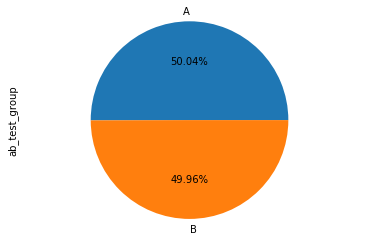

In [8]:
df['ab_test_group'].value_counts().plot.pie(autopct='%.2f%%').axis('equal');

Group A and B have approximately equal sample sizes, so we can proceed with the A/B Testing.


# A/B Testing

In [9]:
df1 = df.copy()

df1['is_applicant']=np.where(df1.application_date.notnull(),1,0)
df1['is_member']=np.where(df1.purchase_date.notnull(),1,0)
df1.sample(5)

,first_name,last_name,gender,email,visit_date,fitness_test_date,application_date,purchase_date,ab_test_group,is_applicant,is_member
270,Ray,Downs,male,RayDowns60@gmail.com,7-13-17,None,None,None,B,0,0
265,Stacey,Beach,female,SBeach1996@gmail.com,7-13-17,None,None,None,B,0,0
3220,Billy,Pugh,male,BillyPugh78@hotmail.com,8-8-17,None,None,None,B,0,0
3906,Lois,Kemp,female,LKemp1991@gmail.com,9-19-17,None,None,None,B,0,0
3336,Shawn,Glover,male,ShawnGlover51@gmail.com,9-1-17,2017-09-06,None,None,A,0,0


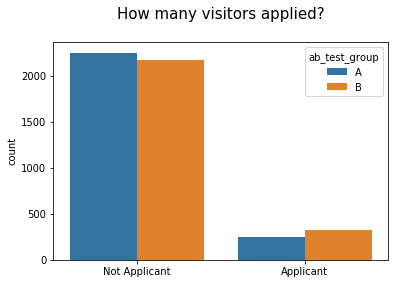

In [10]:
fig, ax = plt.subplots()

ax = sns.countplot(x="is_applicant", hue="ab_test_group", data=df1)
ax.set_xlabel('')
ax.set_xticklabels(['Not Applicant','Applicant'])
ax.set_title('How many visitors applied?',fontsize=15, y=1.08)

plt.show()

It appears that people in Group A (fitness test) are less likely to apply. 

## Hypothesis Test
### Research Question
People from Group A (people who were invited to do a fitness test) were less likely to apply for the gym membership
- Ho: Pa = Pb
- Ha: Pa < Pb

### Check Assumptions
E = n*pi
    - E: expected count
    - n: sample size
    - pi: hypothesized population proportion in the "ith" group    
          (pi = 0.5 for both groups in this case)

In order to use the chi-square distribution to approximate the sampling distribution, all expected counts must be at least five. From `app_pivot` below, we can easily deduct that all expected counts are greater than five.



In [22]:
app_groupby = df1.groupby(['ab_test_group','is_applicant']).first_name.count().reset_index()
app_pivot = app_cnt.pivot_table(values='first_name',index='ab_test_group',columns='is_applicant').reset_index()
app_pivot

is_applicant,ab_test_group,0,1
0,A,2254,250
1,B,2175,325


In [25]:
# contingency table
table = [[2254, 250], [2175, 2175]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)

# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
	print('Dependent (reject Ho)')
else:
	print('Independent (fail to reject Ho)')

# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject Ho)')
else:
	print('Independent (fail to reject Ho)')

[[2254, 250], [2175, 2175]]
dof=1
[[1618.06477969  885.93522031]
 [2810.93522031 1539.06477969]]
probability=0.950, critical=3.841, stat=1111.307
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)



We reject the null hypothesis and accept the alternative hypothesis that Group B has a higher rate of applying for membership. Removing the fitness test can help increasing the application rate.

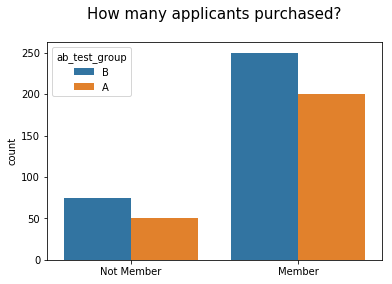

In [40]:
# extract applicants
df2 = df1[df1['is_applicant']==1]
fig, ax = plt.subplots()

ax = sns.countplot(x="is_member", hue="ab_test_group", data=df2)
ax.set_xlabel('')
ax.set_xticklabels(['Not Member','Member'])
ax.set_title('How many applicants purchased?',fontsize=15, y=1.08)

plt.show()

It appears that applicants in Group A (fitness test) are more likely to purchase. 

## Hypothesis Test
### Research Question
People from Group A (people who were invited to do a fitness test) were more likely to purchase the gym membership
- Ho: Pa = Pb
- Ha: Pa > Pb

### Check Assumptions
E = n*pi
    - E: expected count
    - n: sample size
    - pi: hypothesized population proportion in the "ith" group    
          (pi = 0.5 for both groups in this case)

In order to use the chi-square distribution to approximate the sampling distribution, all expected counts must be at least five. From `app_pay_pivot` below, we can easily deduct that all expected counts are greater than five.



In [46]:
app_pay_groupby = df2.groupby(['ab_test_group','is_member']).first_name.count().reset_index()
app_pay_pivot = app_pay_groupby.pivot_table(values='first_name',index='ab_test_group',columns='is_member').reset_index()
app_pay_pivot

is_member,ab_test_group,0,1
0,A,50,200
1,B,75,250


In [38]:
# contingency table
table = [[50, 200], [75, 250]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)

# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

[[50, 200], [75, 250]]
dof=1
[[ 54.34782609 195.65217391]
 [ 70.65217391 254.34782609]]
probability=0.950, critical=3.841, stat=0.616
Independent (fail to reject H0)
significance=0.050, p=0.433
Independent (fail to reject H0)



We don't have enough evidence to reject the null hypothesis. Doing fitness test or not has no statiscally significant effect on the gym membership purchasing decision.

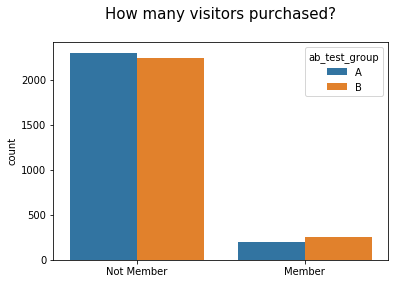

In [41]:
fig, ax = plt.subplots()

ax = sns.countplot(x="is_member", hue="ab_test_group", data=df1)
ax.set_xlabel('')
ax.set_xticklabels(['Not Member','Member'])
ax.set_title('How many visitors purchased?',fontsize=15, y=1.08)

plt.show()

It appears that applicants in Group A (fitness test) are less likely to purchase. 

## Hypothesis Test
### Research Question
People from Group A (people who were invited to do a fitness test) were less likely to purchase the gym membership
- Ho: Pa = Pb
- Ha: Pa < Pb

### Check Assumptions
E = n*pi
    - E: expected count
    - n: sample size
    - pi: hypothesized population proportion in the "ith" group    
          (pi = 0.5 for both groups in this case)

In order to use the chi-square distribution to approximate the sampling distribution, all expected counts must be at least five. From `all_pay_pivot` below, we can easily deduct that all expected counts are greater than five.



In [44]:
all_pay_groupby = df1.groupby(['ab_test_group','is_member']).first_name.count().reset_index()
all_pay_pivot = all_pay_groupby.pivot_table(values='first_name',index='ab_test_group',columns='is_member').reset_index()
all_pay_pivot

is_member,ab_test_group,0,1
0,A,2304,200
1,B,2250,250


In [45]:
# contingency table
table = [[2304, 200], [2250, 250]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)

# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

[[2304, 200], [2250, 250]]
dof=1
[[2278.82014388  225.17985612]
 [2275.17985612  224.82014388]]
probability=0.950, critical=3.841, stat=5.949
Dependent (reject H0)
significance=0.050, p=0.015
Dependent (reject H0)



We reject the null hypothesis and accept the alternative hypothesis that Group B has a higher rate of purchasing the membership. Removing the fitness test can help increasing the purchasing rate.

## Summary
Out of the 3 A/B Testings, the first and the third were proven to be statistically significant. We are confident to conclude that removing the fitness test will help bring more applications and purchases.
